### Click path data from Yoochoose GmbH
---

YOOCHOOSE e-commerce data set by YOOCHOOSE GmbH is licensed under a [Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License](https://creativecommons.org/licenses/by-nc-nd/4.0/). 
Data files explanation: http://recsys.yoochoose.net/challenge.html

---
The yoochoose-buys.dat includes the purchases made (some are 0), session numbers, timestamps, ID's of the items bought and prices. 

Yoochoose-clicks.dat contains clicks by 
session, timestamps and item ID's.

### Examining the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get the purchases data
buys = pd.read_csv("data/yoochoose-buys.dat", names=['session', 'timestamp','itemID','price','quantity'])

# Get the clicks data, and set labels and column types
clicks = pd.read_csv("data/yoochoose-clicks.dat", names=['session', 'timestamp','itemID', 'cat'], 
                     dtype = {'session': np.int64, 'timestamp': np.object,'itemID': np.int64, 'cat' : np.object})

# Let's see the clicks of session 420374
clicks.loc[clicks['session'] == 420374]

,session,timestamp,itemID,cat
1235499,420374,2014-04-06T18:41:46.649Z,214537888,0
1235500,420374,2014-04-06T18:41:50.292Z,214537888,0
1235501,420374,2014-04-06T18:42:33.117Z,214537850,0
1235502,420374,2014-04-06T18:42:38.784Z,214537850,0
1235503,420374,2014-04-06T18:43:02.611Z,214537888,0
1235504,420374,2014-04-06T18:43:10.786Z,214537888,0


In [10]:
# Let's see which of the sessions have most purchases
print("Most purchases: \n\n", buys['session'].value_counts().head(10))
print("\n")

# How many clicks has the "top buys" -session nr 5638444
klik = clicks.loc[clicks['session'] == 5638444].reset_index()
print("Most bought item: \n\n 5638444\n",klik.count())

Most purchases: 

 5638444     144
10808253    120
9014734      81
428198       72
6832724      72
6149111      64
601904       62
2233614      54
10683806     54
7586548      54
Name: session, dtype: int64


Most bought item: 

 5638444
 index        65
session      65
timestamp    65
itemID       65
cat          65
dtype: int64


---
Now, we'd like to see how many times each quantity of items appears in purchases

In [14]:
# Let's count the unique amounts in 'quantity'
types = pd.Series(buys['quantity'].values.ravel()).unique()
types.sort() # ... and sort them
print("Quantity types: ", types, "Array length: ", len(types),"\n")

# And now let's count how many occurrances are there of each 'quantity', with numpy bincount:
amounts = np.bincount(buys['quantity'].astype(int))
print("How many times each quantity of items was bought at the same time: \n", amounts, "Array Length: ", len(amounts))

Quantity types:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26
 28 29 30] Array length:  28 

How many times each quantity of items was bought at the same time: 
 [610030 435065  75486  11050   7505   2670   4477    397    588    145
   1887      7    648      9      8     26     16      2    144      2
    126      8      0      0    227      2      1      0      2      1
    224] Array Length:  31


--- 
So, quantity '0' appears 610030 times, '1' appears 435065 times, and so on... But,
as we can see, array lengths don't match. That's because *bincount* counts also occurrances 
of 22, 23 and 27 although they are '0'. 

So, we drop the zero values.

In [28]:
# First let's find out indices of 0's...
index = np.argwhere(amounts==0)
# ...then delete them by index.
amounts = np.delete(amounts, index)

# Let's see how many invoices are there with each quantity of items bought at once
ostot = pd.DataFrame(amounts, columns=["times appears"])
ostot['quantities'] = types
print(ostot)

    times appears  quantities
0          610030           0
1          435065           1
2           75486           2
3           11050           3
4            7505           4
5            2670           5
6            4477           6
7             397           7
8             588           8
9             145           9
10           1887          10
11              7          11
12            648          12
13              9          13
14              8          14
15             26          15
16             16          16
17              2          17
18            144          18
19              2          19
20            126          20
21              8          21
22            227          24
23              2          25
24              1          26
25              2          28
26              1          29
27            224          30


### Datatypes conversion and concatenating *clicks* and *buys* dataframes
In the buys-data, we have the number of purchases per session, but we want to just turn all purchases to 1, so we don't care how many items were bought per a session's timestamp,
only if there were purchases or not. We can achieve this by converting the quantity column to bool and then back to int:  

In [30]:
# Let's make a '0' for non-purchase, and a '1' for a purchase.
print(buys.iloc[[289,296]]) # example row
buys.quantity = buys.quantity.astype(bool).astype(int)
print("\n\n", buys.iloc[[289,296]]) # example row modified

     session                 timestamp     itemID  price  quantity
289   281963  2014-04-07T20:33:54.828Z  214563144      0         0
296   489588  2014-04-02T20:54:01.198Z  214820231   1046         6


      session                 timestamp     itemID  price  quantity
289   281963  2014-04-07T20:33:54.828Z  214563144      0         0
296   489588  2014-04-02T20:54:01.198Z  214820231   1046         1


In [41]:
import datetime # Let's measure the time for this operation
timestart = datetime.datetime.now()


# ".append"
# Append 'clicks' to 'buys', creating the 'times' dataframe (leaving 'cat' column out of 'clicks' dataframe)
times = buys.append(clicks.loc[:,['session', 'timestamp','itemID']])


clock = datetime.datetime.now() - timestart
print(clock)

0:00:02.595136


In [37]:
# We could have used 'concat', but in this case append is better, as we get the quantity column at once.
# And there isn't a significant difference in processing time

# aika = datetime.datetime.now()
# times = pd.concat([buys[['session', 'timestamp']], clicks[['session', 'timestamp']]]) 
# kesto = datetime.datetime.now() - aika
# print(kesto)

0:00:01.394710


### Parse date and time

The time stamp has extra characters, and we have to parse date and time out of the strings.
We split the data by "T" and then "." ,and finally join the elements.

In [48]:
times.head(1)

,itemID,price,quantity,session,timestamp,time
1150753,214536502,NaN,NaN,1,2014-04-07T10:51:09.277Z,2014-04-07 10:51:09


In [49]:
# This is the function to parse date and time from timestamp. 
# Split data by T and then "." ,and finally join the elements.
def parsetime(time):
    getdate = time.split('T')[0]+" "+time.split('T')[1].split('.')[0]  
    return(getdate)

In [46]:
# This, first version of the function, was A LOT slower:
def parsetime_slow(time):
    getdate = time.split('T')[0]
    gettime = time.split('T')[1].split('.')[0]
    return(pd.to_datetime(getdate+" "+gettime))


#timestart = datetime.datetime.now()
#times['time'] = times['timestamp'].map(parsetime_slow)
#clock = datetime.datetime.now() - timestart
#print(clock)

0:25:00.276561


In [50]:
timestart = datetime.datetime.now() # Measure time for this operation


# Parse time out of timestamp and add to a new column 'time'
times['time'] = 0
times['time'] = times['timestamp'].map(parsetime)

# Reset index and sort by sessions
times.reset_index(inplace=True, drop=True)
times.sort_values(by=['session'], inplace=True)
times.head()


# let's count and print the duration of this operation:
clock = datetime.datetime.now() - timestart
print(clock)

0:00:34.695699


In [51]:
# Before we can compare times & dates, we have to convert 'time' column to Pandas datetime -object
times['time'] = pd.to_datetime(times['time'])
times.head()

,itemID,price,quantity,session,timestamp,time
0,214536502,NaN,NaN,1,2014-04-07T10:51:09.277Z,2014-04-07 10:51:09
1,214536500,NaN,NaN,1,2014-04-07T10:54:09.868Z,2014-04-07 10:54:09
2,214536506,NaN,NaN,1,2014-04-07T10:54:46.998Z,2014-04-07 10:54:46
3,214577561,NaN,NaN,1,2014-04-07T10:57:00.306Z,2014-04-07 10:57:00
4,214757390,NaN,NaN,2,2014-04-07T13:59:50.710Z,2014-04-07 13:59:50


### Count time spent on a session

Now we need to get the first and last timestamp of each session, and count the difference.

We could use groupby and then get max and min from the groupby-object, but this turned out to be very slow

>  group_by_session = times.groupby(by=["session"])

>  time_out = group_by_session.max(col="time")

>  time_in = group_by_session.min(col="time")

>  sessions['time_spent'] = pd.to_datetime(time_out['time']) - pd.to_datetime(time_in['time'])



Faster method:

Groupby's '.agg'-method is faster. So we group 'times'-dataframe by sessions, and get min and max values

In [54]:
# let's count the time consumed
timestart = datetime.datetime.now()

# get min and max
session = times.groupby('session').time.agg(['min', 'max'])

# Now we can count duration of sessions. And add it to a new column
session['time_spent'] = session['max'] - session['min']



# let's count and print the duration of this operation:
clock = datetime.datetime.now() - timestart
print(clock)

0:00:03.575236


In [55]:
# Now let's group 'buys' by sessions, and count items purchased
group_by_session_buys = buys.groupby(by=['session'])
purchases = group_by_session_buys['quantity'].count()
purchases = pd.DataFrame(purchases)
print(purchases[:5])

         quantity
session          
11              2
12              1
21              2
33              6
46              2


Now, we could replace all purchases from 'purchases' to session dataframe by iteration, but
this is terribly slow (hours!)

> for i in range(len(sessions)):

>    if (e < len(purchases)):

>        if (sessions['purchased'].index[i] == purchases.index[e]):

>            sessions['purchased'].iloc[i] = purchases.iloc[e]

>            e+=1

So, we can use pandas methods instead (very fast!).
The 'purchases' dataframe contains indices of the sessions that are not 0, and quantity.

Now we look for matching session indices in *session* and *purchases*, and 
if found, replace session['purchase'] with purchases['quantity']


In [56]:
# Add 'purchase_count' column to sessions, and first assign them all to zero
session['purchase_count'] = 0

# Replace matching indices with purchase quantities
session.loc[session['purchase_count'
                     ].index.isin(purchases['quantity'].index),'purchase_count'] = purchases['quantity']

# Let's count clicks per session and add to new column
group_by_session = times.groupby(by=["session"])
session['clicks_in_session'] = group_by_session['time'].count()

session.loc[7:12, 'time_spent':'clicks_in_session']

,time_spent,purchase_count,clicks_in_session
session,,,
7,00:00:12,0,2
8,00:02:14,0,2
9,00:02:49,0,3
11,00:19:43,2,14
12,00:12:04,1,3


Now we can get nice statistics about the data. 

This piece of data would let us think, that more clicks and more time mean more purchases.

Before we can analyze correlation, we have to convert time to integers (seconds) with *pandas.Series.dt.total_seconds*


In [59]:
session['time_spent_sec'] = session['time_spent'].dt.total_seconds().apply(int)
session.loc[5638440:5638450, 'time_spent':'time_spent_sec']

,time_spent,purchase_count,clicks_in_session,time_spent_sec
session,,,,
5638441,00:14:28,0,4,868
5638442,00:02:21,0,3,141
5638443,00:03:45,0,4,225
5638444,02:37:46,144,209,9466
5638446,00:00:18,0,4,18
5638447,00:02:46,0,3,166
5638448,00:01:16,0,3,76
5638449,00:03:06,0,3,186


In [62]:
# Let's see correlations

print("Average time spent on site (seconds):  \n",session['time_spent_sec'].mean())
print("\nAverage time of sessions that lead to purchase:  \n",session.loc[session['purchase_count'] > 0, 'time_spent_sec'].mean())
print("\nAverage time of sessions that did not lead to purchase:  \n",session.loc[session['purchase_count'] == 0, 'time_spent_sec'].mean())


corrs = session.corr()
print("\n\n",corrs)

Average time spent on site (seconds):  
 404.8591217104847

Average time of sessions that lead to purchase:  
 1288.5981526243095

Average time of sessions that did not lead to purchase:  
 353.32175919701905


                    purchase_count  clicks_in_session  time_spent_sec
purchase_count           1.000000           0.435151        0.260072
clicks_in_session        0.435151           1.000000        0.558194
time_spent_sec           0.260072           0.558194        1.000000


## Visualising with NetworkX

With the following function, we add edges and nodes to a NetworkX's MultiDiGraph, which is a directed graph with self 
loops and parallel edges.

1. At the last entry of data, a node is added, otherwise add an edge. 

2. If 'quantity' is empty, add an edge with red color and size of 200, otherwise color is green and size 400.


In [255]:
# This function is used to add nodes and edges to the graph
def edgesnodes(clickstream, colors, sizes, labels, col_to_edges):
    for i in range(0,len(testi)):
        # If this is the last value, add a node. Set color depending on quantity 
        if (i == len(testi)-1):           
            clickstream.add_node(testi[col_to_edges][i], weight=10.1)                
            if (np.isnan(testi['quantity'][i])):
                colors.append('red')
                sizes.append(200)
            else:
                colors.append('green')
                sizes.append(400)
        # If not the last value, add edge, and set color
        else:
            if (np.isnan(testi['quantity'][i])):
                clickstream.add_edge(testi[col_to_edges][i], testi[col_to_edges][i+1], weight=0.1)
                colors.append('red')
                sizes.append(200)
                labels[testi[col_to_edges][i], testi[col_to_edges][i+1]] = "clicked "+str(testi['itemID'][i])
            else:
                clickstream.add_edge(testi[col_to_edges][i], testi[col_to_edges][i+1], weight=0.1)
                colors.append('green')
                sizes.append(400)
                labels[testi[col_to_edges][i], testi[col_to_edges][i+1]] = "PURCHASE "+str(testi['itemID'][i])
    return(clickstream, colors, sizes, labels)

### NetworkX MultiDiGraph

In the next graph the nodes, edges and labels are drawn separately. The thicker head of line is the head of an arrow, marking the direction. Red dots are clicks, green dots are purchases.

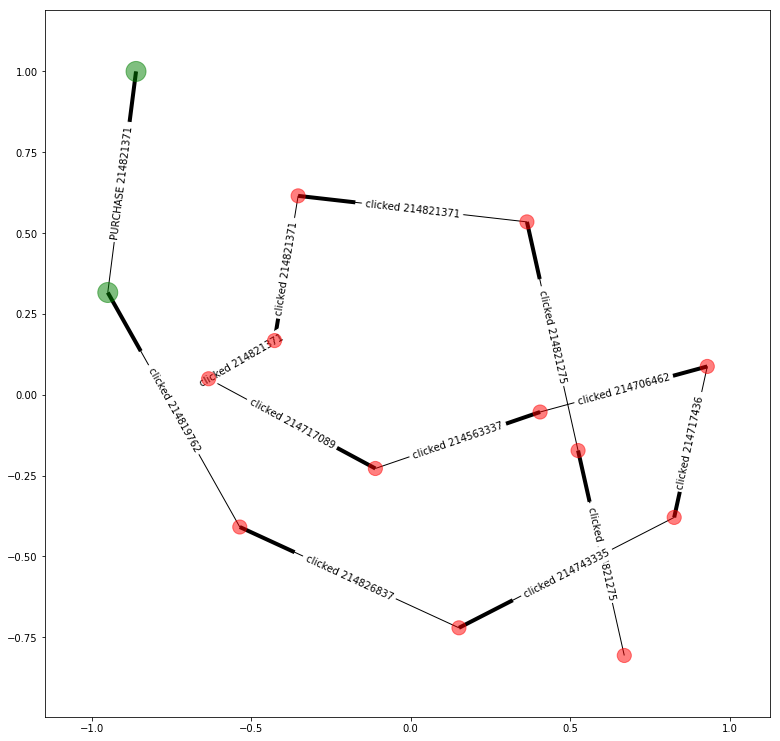

In [256]:
# Let's visualise data from one particular session with networkx
import networkx as nx

# Take session 11 as data
testi = times.loc[times['session']==11]
testi = testi.sort_values('time')
testi.reset_index(inplace=True, drop=True)

# Create new graph
clickstream = nx.MultiDiGraph() 

# init variables
colors = []
sizes = []
labels = {}  
    
# What column to use as edges:
col_to_edges = 'time'
edgesnodes(clickstream, colors, sizes, labels, col_to_edges)           
                
# Draw the figure
fig = plt.figure(figsize=(13,13))

# Get the positions for all nodes
pos=nx.spring_layout(clickstream) 

# draw nodes
nx.draw_networkx_nodes(clickstream, pos, arrows=True, with_labels=True,
                    font_size=24, alpha=0.5, node_color = colors, node_size = sizes)
# draw edges
nx.draw_networkx_edges(clickstream, pos)

# draw labels
nx.draw_networkx_edge_labels(clickstream,pos,labels)

plt.show()

### Spectral

We can also visualise a click path with a spectral graph, in which we can more clearly see, that this particular visitor started with item 214821275, was then looking at item 214821371, and then came back to buy it.

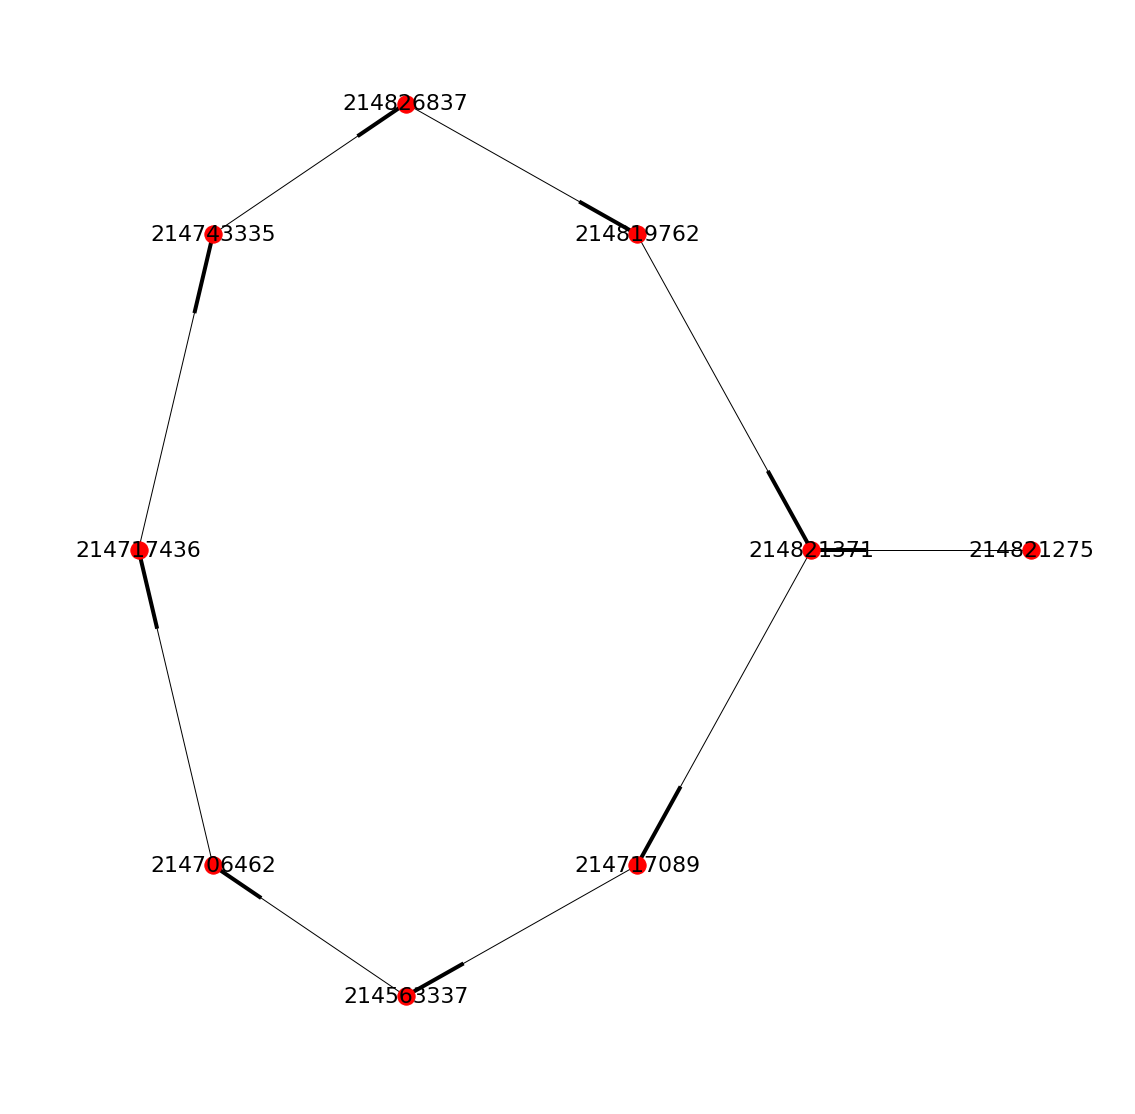

In [279]:
# Let's visualise data from one particular session
testi = times.loc[times['session']==11] #5638444
testi = testi.sort_values('time')
testi.reset_index(inplace=True, drop=True)

clickstream = nx.MultiDiGraph() 

# Let's have itemID as edges
col_to_edges = 'itemID'
edgesnodes(clickstream, colors, sizes, labels, col_to_edges)
                
# Draw the figure
fig = plt.figure(figsize=(15,15))
nx.draw_spectral(clickstream, with_labels=True, font_size=22)
plt.show()

### Kamada kawai

This "kamada kawai" graph visualises clicks of one visitor. RED means clicking an item, GREEN means a purchase.

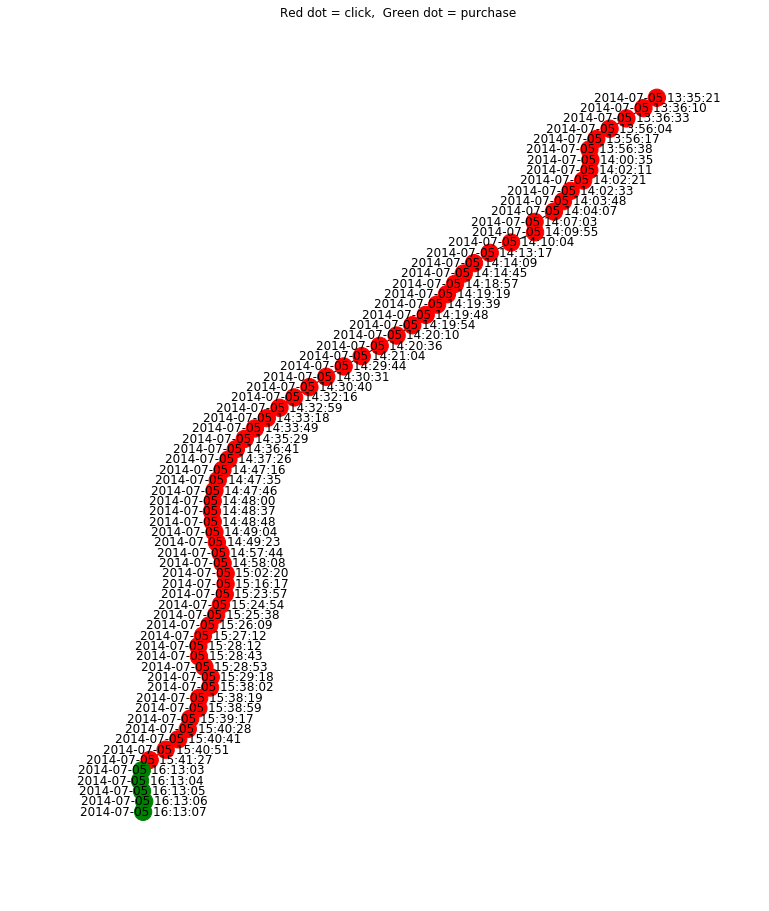

In [132]:
# Let's visualise data from one particular session, 5638444
testi = times.loc[times['session']==5638444] 
testi = testi.sort_values('time')
testi.reset_index(inplace=True, drop=True)

clickstream = nx.MultiDiGraph() 
colors2 = []
sizes2 = []
# Let's have time as edges
col_to_edges = 'time'
edgesnodes(clickstream, colors2, sizes2, labels, col_to_edges)
                
# Draw the figure
fig = plt.figure(figsize=(10,12))
nx.draw_networkx
nx.draw_kamada_kawai(clickstream, with_labels=True, node_color=colors2, sizes=sizes2)

plt.title("Red dot = click,  Green dot = purchase")
plt.show()